# DBSCAN

In [59]:
import pandas as pd
import numpy as np

In [60]:
class Point:
    def __init__(self, coordinates, type, neighboringPoints, cluster):
        self.coordinates = coordinates
        self.type = type    # For 1 for core point, 2 for border point and 3 for outlier
        self.neighboringPoints = neighboringPoints
        self.cluster = cluster


In [61]:
def EuclDist(x, p, eps, MinPts):
    NeighboringPoints = []
    type = 0
    for j in range(len(x)):
        point = x[j]
        dist = 0
        for i in range(len(point)):
            dist = dist + (point[i] - p[i]) ** 2
        dist = dist ** (1 / 2)
        if dist < eps:
            NeighboringPoints.append(j)     # The point is not added rather the index is added.
    if len(NeighboringPoints) > MinPts:
        type = 1 # Core Point
    elif len(NeighboringPoints) > 1:
        type = 2 # Non Core Point
    else:
        type = 3 # Outlier

    return [NeighboringPoints, type]

In [62]:
def DBscan(x, eps, MinPts):
    currentCluster = 0
    points = []

    for data in x:
        [NeighboringPoints, type] = EuclDist(x, data, eps, MinPts)
        points.append(Point(data, type, NeighboringPoints, 1 - type))       # This is done to ensure a core point that has not been clustered yet.
    for i in range(len(x)):
        if points[i].cluster == 0:  # Core point not yet clustered
            currentCluster = currentCluster + 1
            points[i].cluster = currentCluster
            findClusterPoints(x, currentCluster, points, i, eps, MinPts)
        
    return points

In [63]:
def findClusterPoints(x, currentCluster, points, position, eps, MinPts):
    ClusterMembers = points[position].neighboringPoints
    i = 0
    while i < len(ClusterMembers):
        expansionPoint = ClusterMembers[i]
        if points[expansionPoint].cluster == -1:
            points[expansionPoint].cluster = currentCluster
        elif points[expansionPoint].cluster == 0:
            points[expansionPoint].cluster = currentCluster
            ClusterMembers = ClusterMembers + points[expansionPoint].neighboringPoints
        i = i + 1

In [64]:
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

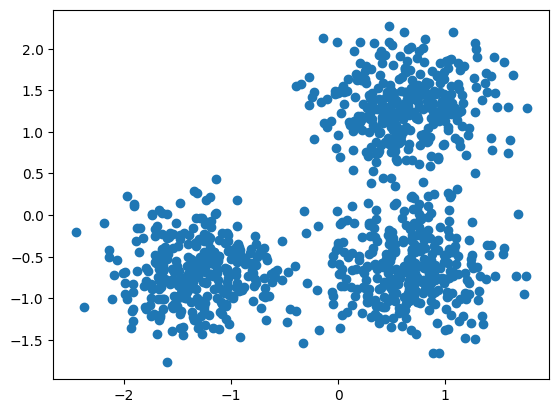

In [65]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=1000, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1])

In [66]:
points = DBscan(X, eps=0.2, MinPts=5)
clusters = []
for point in points:
    clusters.append(point.cluster)

In [ ]:
df = pd.DataFrame(X, columns = ["x", "y"])
df['clusters'] = np.array(clusters)
df = df.sort_values("clusters")
df['clusters'] = df['clusters'].apply(lambda x: 'Outliers' if x == -2 else x)
df['clusters'] = df['clusters'].apply(lambda x: "Border points that don't belong to clusters" if x == -1 else x)
# These are the points which are close to non core points
df

,x,y,clusters
959,-0.939852,0.186722,Outliers
627,1.070245,2.199491,Outliers
734,-1.137168,0.433237,Outliers
632,-2.179587,-0.100394,Outliers
789,-1.593931,-1.771422,Outliers
...,...,...,...
61,-1.470791,0.143213,3
49,-1.253475,-0.307248,3
50,-1.036570,-0.680084,3
54,-1.020905,-0.705682,3


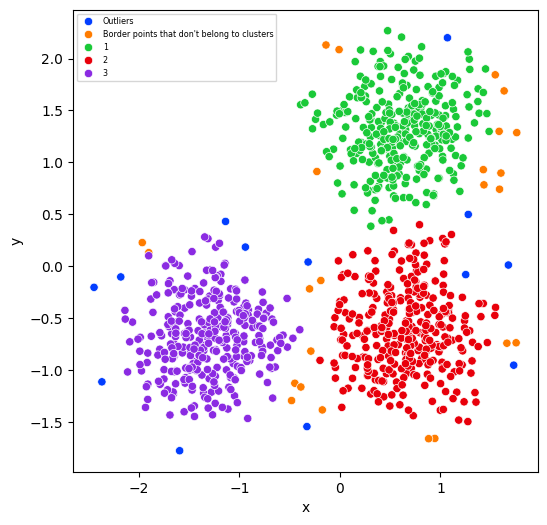

In [68]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data = df, x = "x", y = "y", hue = "clusters", palette = "bright")
plt.legend(fontsize='xx-small')
plt.show()

In [69]:
from sklearn.cluster import DBSCAN
import time
ourTimes = []
sklearnTimes = []
centers = [[1, 1], [-1, -1], [1, -1]]
for i in range(10):
    X, labels_true = make_blobs(
        n_samples=200 * (i + 1), centers=centers, cluster_std=0.4, random_state=0
    )
    X = StandardScaler().fit_transform(X)
    start = time.time()
    db = DBSCAN(eps=0.3, min_samples=5).fit(X)
    end = time.time()
    sklearnTimes.append(end - start)
    start = time.time()
    points = DBscan(X, 0.3, 5)
    end = time.time()
    ourTimes.append(end-start)

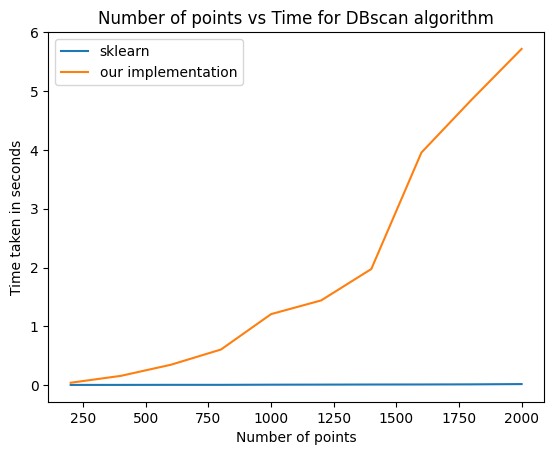

In [70]:
#We note a quadratic relationship between number of points and time taken
xaxis = [200 * (i+1) for i in range(10)]
plt.plot(xaxis, sklearnTimes)
plt.plot(xaxis, ourTimes)
plt.title('Number of points vs Time for DBscan algorithm')
plt.xlabel('Number of points')
plt.ylabel('Time taken in seconds')
plt.legend(['sklearn', 'our implementation'])
plt.show()

# Kmeans 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [6]:
class Kmeans:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        np.random.seed(42)

        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [X[idx] for idx in random_sample_idxs]

        for _ in range(self.max_iters):
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        return self._get_cluster_labels(self.clusters)
    
    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx

        return labels
    
    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]

        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroids(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroids(self, sample, centroids):
        distances = [euclidean_distance(sample, point) for point in centroids]    
        closest_idx = np.argmin(distances)
        return closest_idx
    
    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    
    def _is_converged(self, centroids_old, centroids):
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()

(500, 2)
3


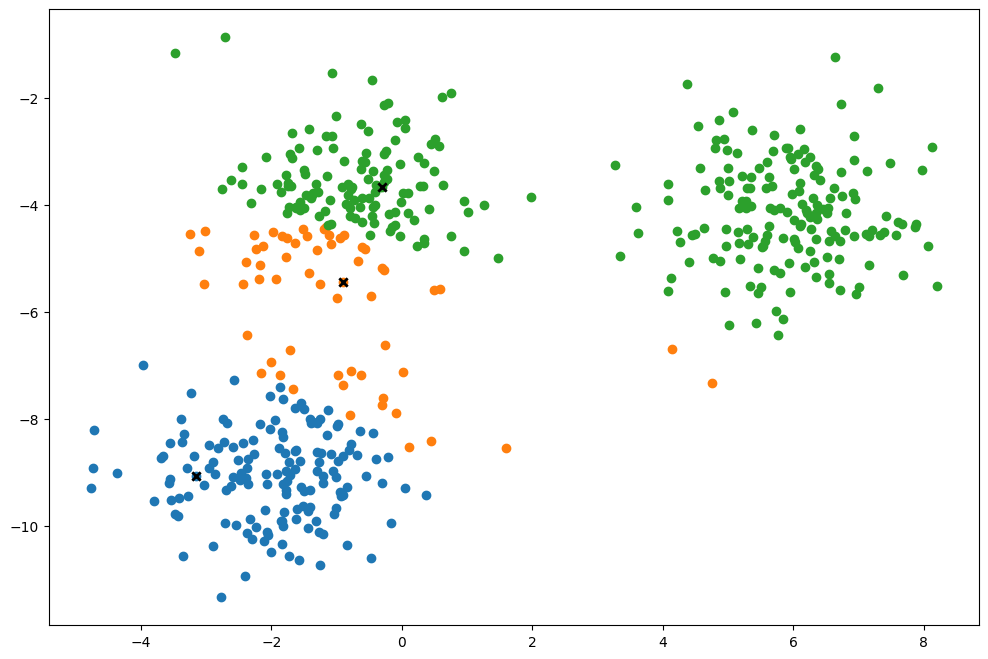

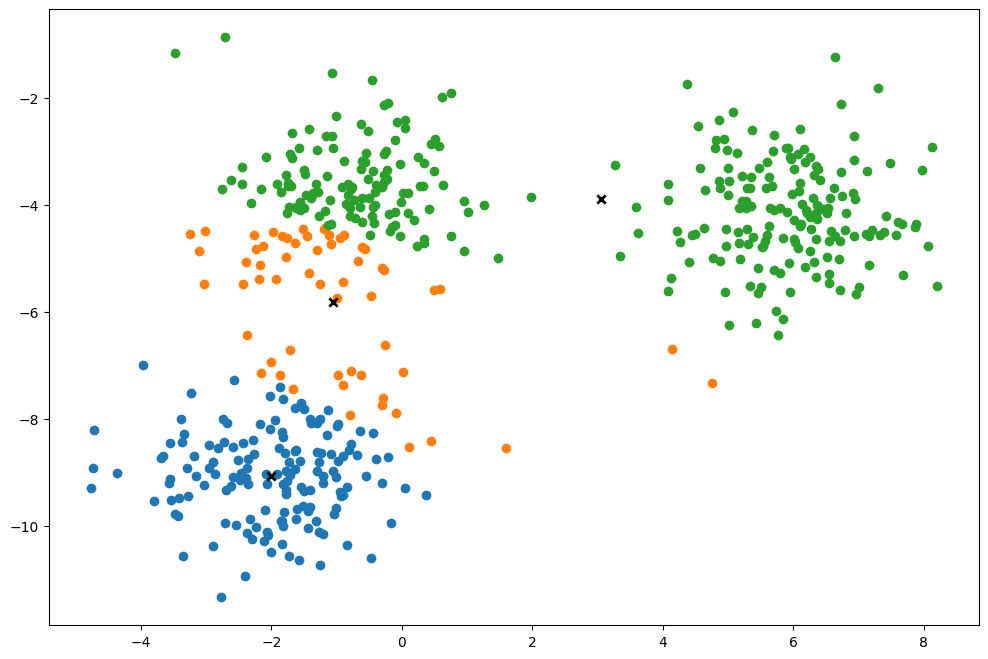

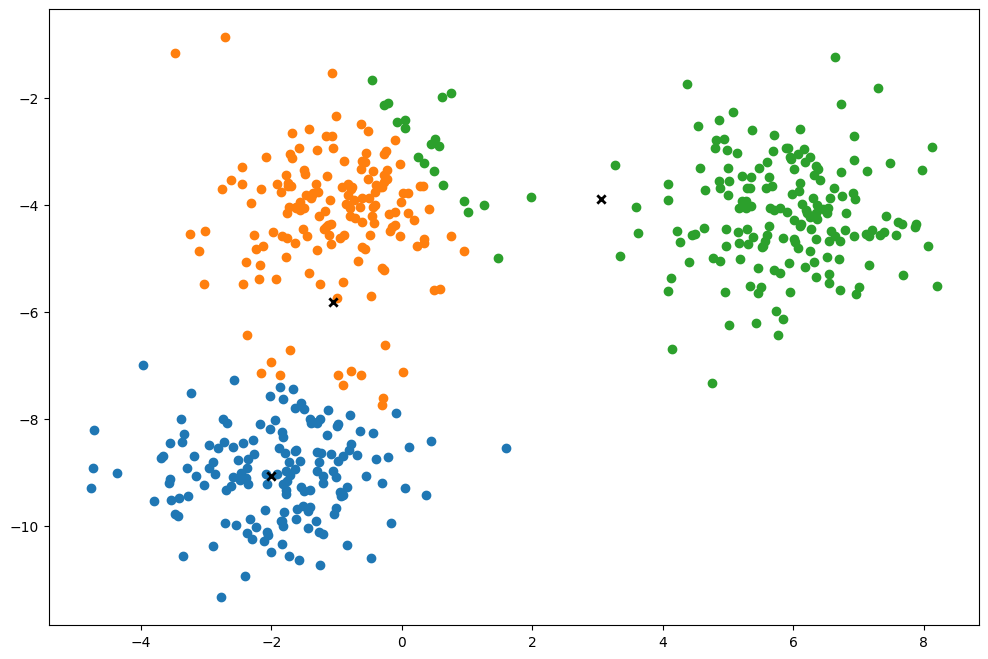

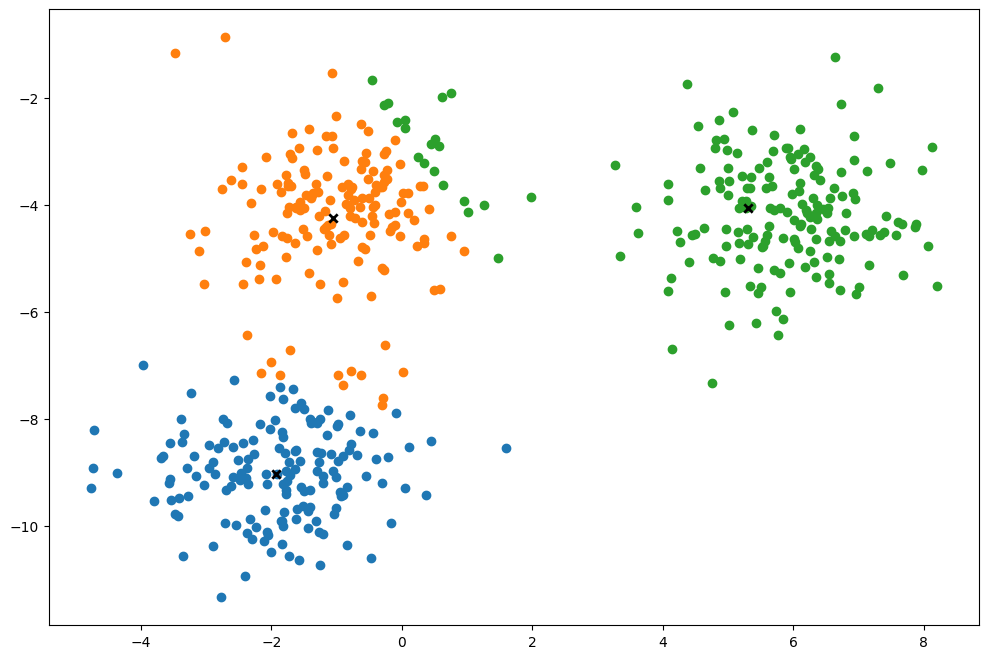

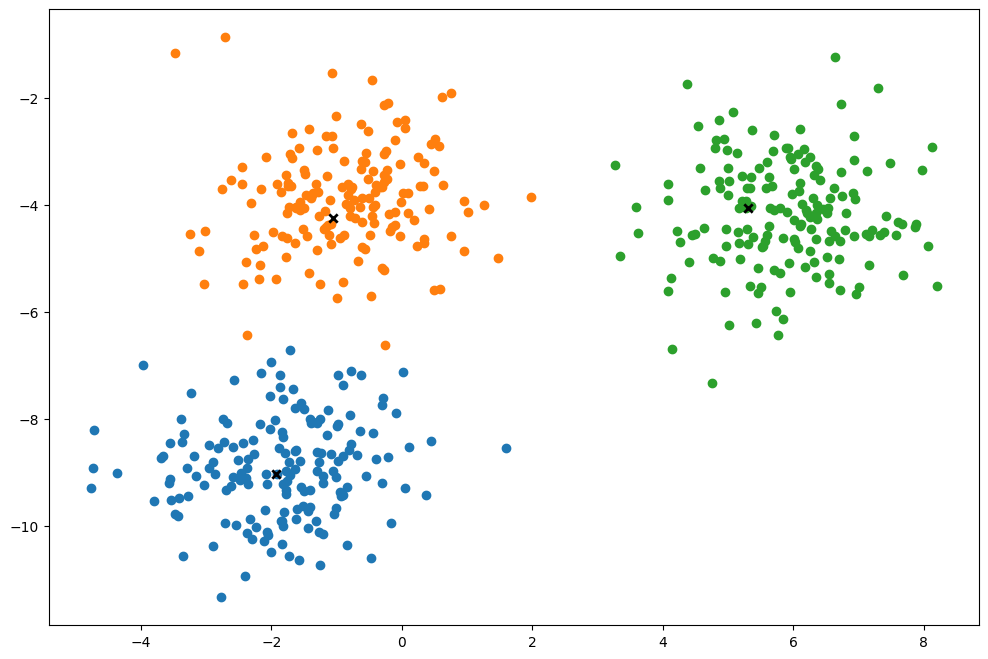

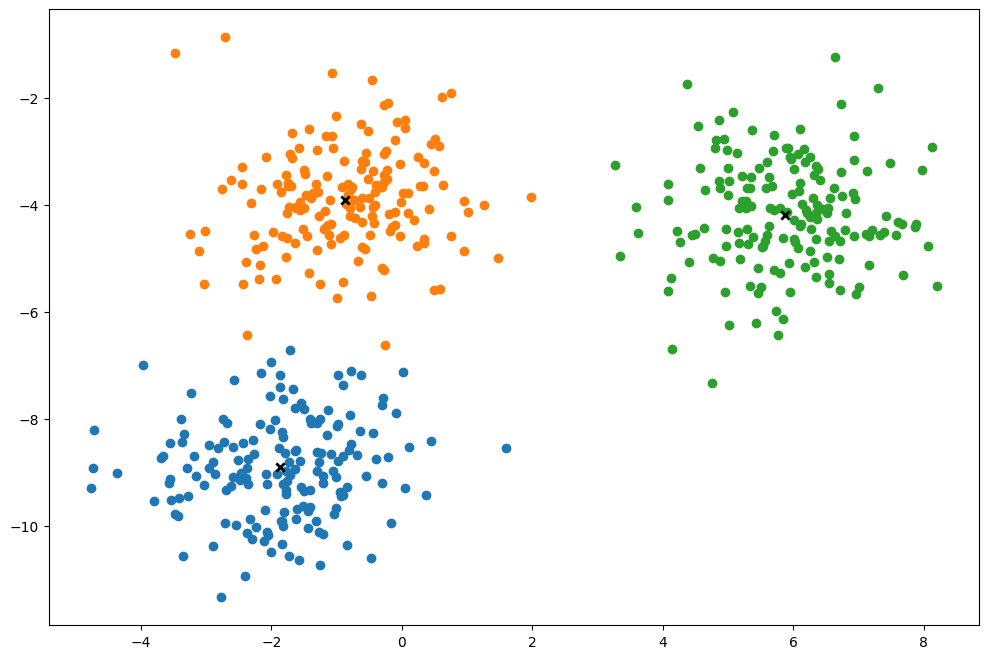

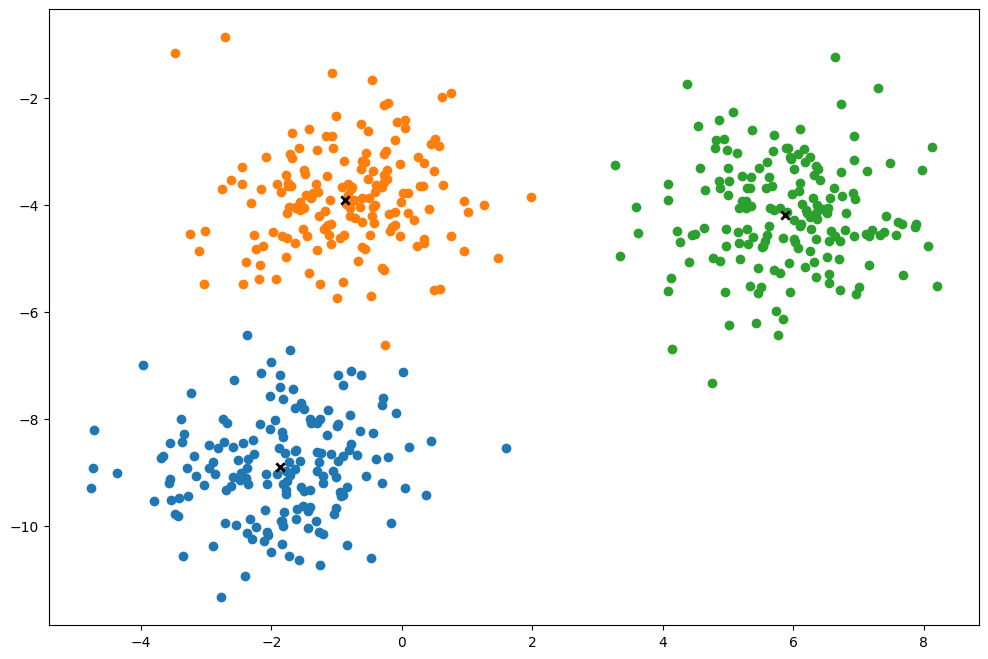

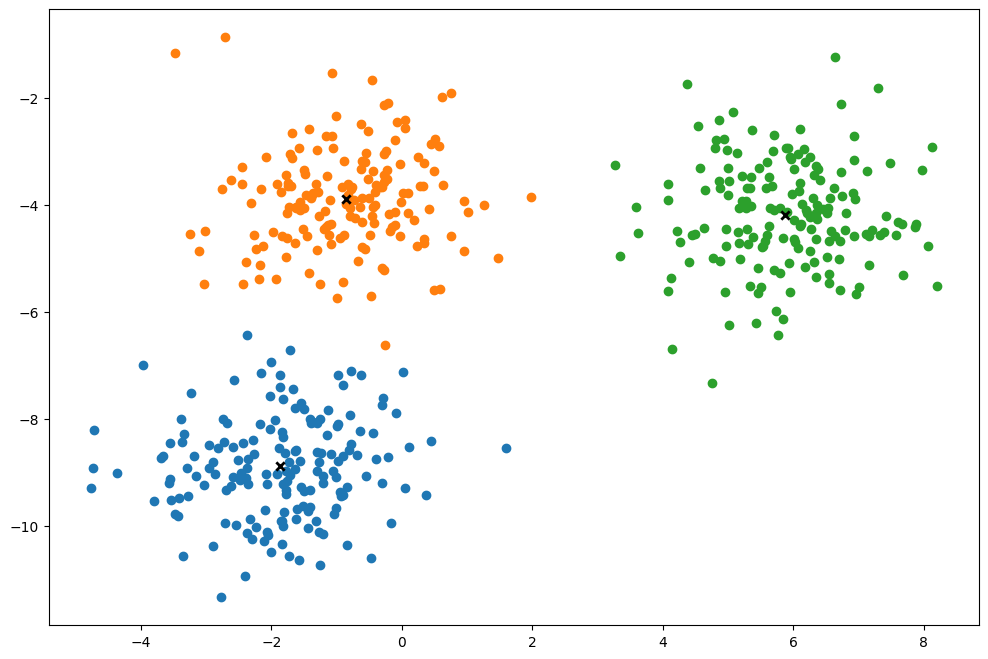

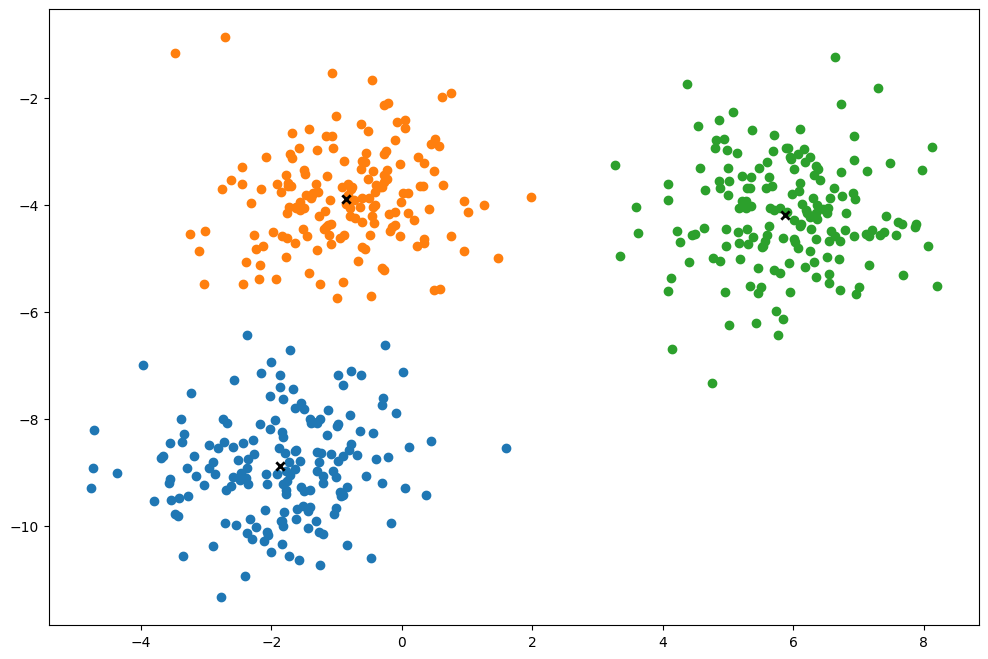

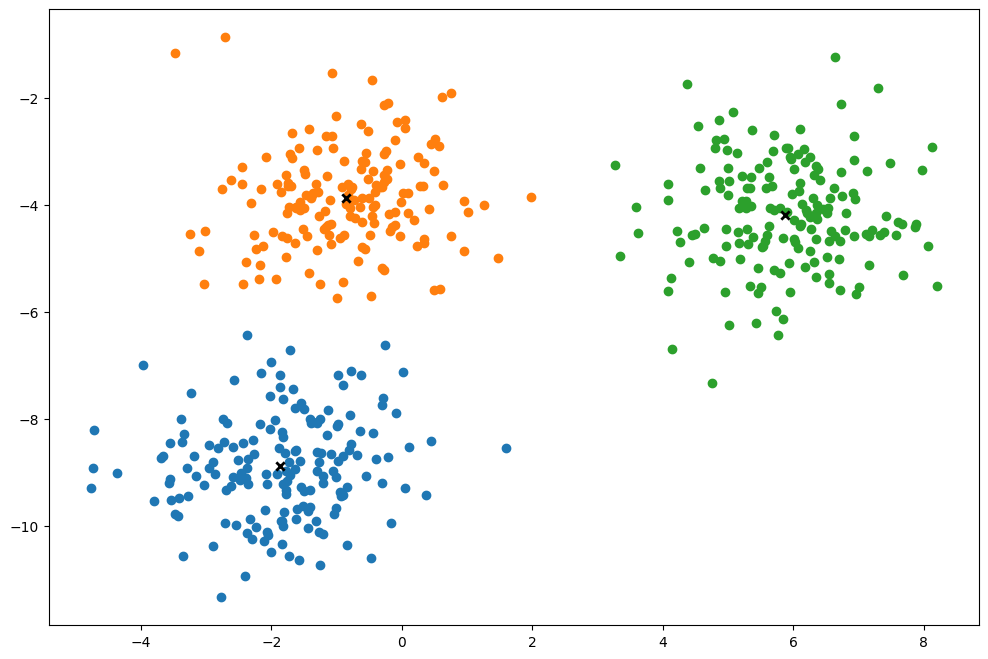

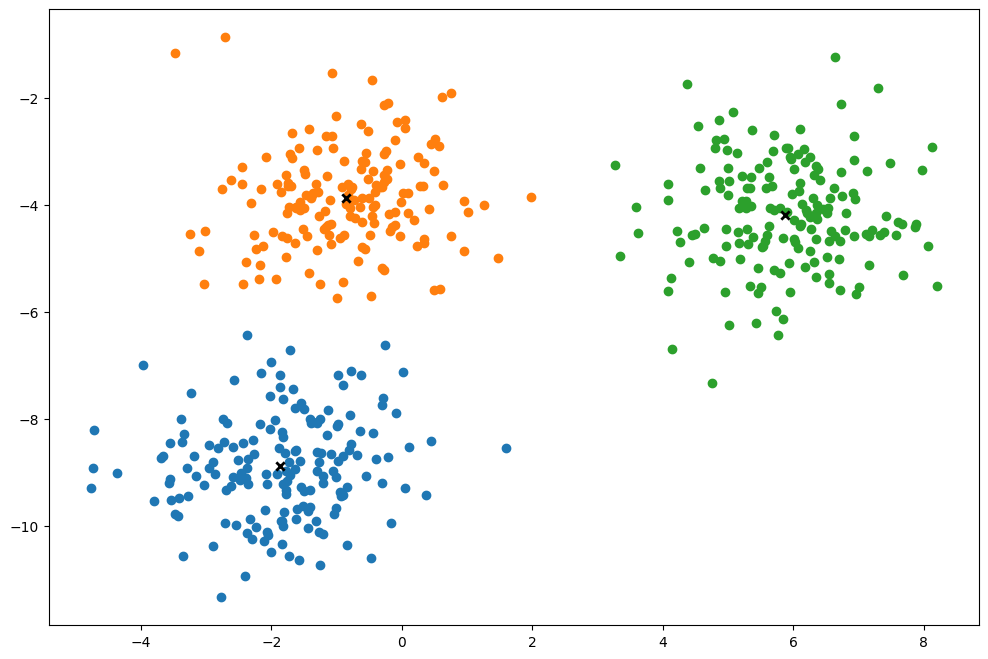

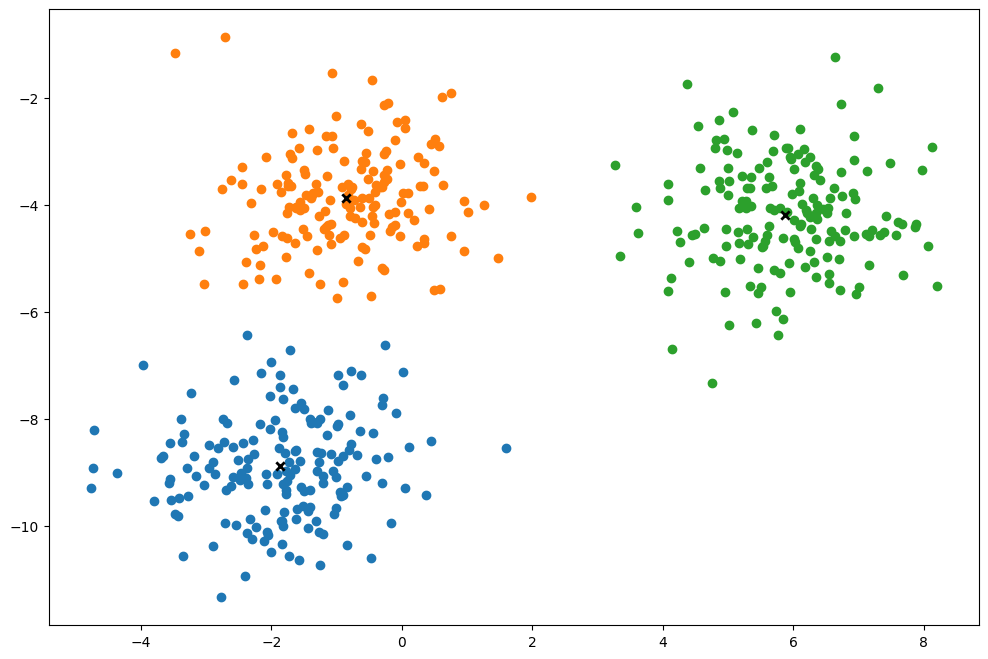

In [7]:

np.random.seed(42)
from sklearn.datasets import make_blobs
X, y = make_blobs(
    centers=3, n_samples=500, n_features=2, shuffle=True, random_state=40
)
print(X.shape)
clusters = len(np.unique(y))
print(clusters)
k = Kmeans(K=clusters, max_iters=150, plot_steps=True)
y_pred = k.predict(X)
k.plot()

# Kmeans 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [6]:
def ed_distance(x1, x2):
    return (np.sum((x1 - x2) ** 2))

In [7]:
# kmeans ++ init for choosing the initial points so as far as possible

def kmeans_plus_plus_init(X, k, seed=0):
    np.random.seed(seed)
    n_samples, n_features = X.shape
    centroids = np.zeros((k, n_features))
    centroids[0] = X[np.random.choice(n_samples)]
    closest = np.full(n_samples, np.inf)

    for idx in range(1, k):
        dist_centroids = [ed_distance(x, centroids[idx - 1]) for x in X]
        closest = np.minimum(closest, dist_centroids)
        probs = closest / closest.sum()
        cumu_probs = np.cumsum(probs)
        r = np.random.rand()
        next_idx = np.searchsorted(cumu_probs, r)
        centroids[idx] = X[next_idx]
    return centroids

In [8]:
def closest_centroids(sample, centroids):
    distances = [euclidean_distance(sample, point) for point in centroids]
    closest_idx = np.argmin(distances)
    return closest_idx

In [11]:
def assign_clusters(X, centroids):
    labels = []
    for idx, sample in enumerate(X):
        centroid_idx = closest_centroids(sample, centroids)
        labels.append(centroid_idx)
    return np.array(labels)

In [12]:
def update_centroids(X, labels, k):
    n = X.shape[1]
    centroids = np.zeros((k, n))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            centroids[i] = X[np.random.choice(len(X))]
        else:
            centroids[i] = cluster_points.mean(axis=0)

    return centroids

In [13]:
def compute_wcss(X, labels, centroids):
    total = 0.0
    for k in range(len(centroids)):
        cluster_points = X[labels == k]
        dists = [ed_distance(sample, centroids[k]) for sample in cluster_points]
        total += sum(dists)

    return total

In [14]:
def compute_j(X, labels, centroids):
    wcss = compute_wcss(X, labels, centroids)
    return wcss / X.shape[0]

In [15]:
def kmeans(X, k, epochs, seed=0):
    centroids = kmeans_plus_plus_init(X, k, seed)
    for i in range(epochs):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    labels = assign_clusters(X, centroids)
    return centroids, labels

In [16]:
def kneedle_elbow(kmax, wcss_list):
    x1, y1 = 1, wcss_list[0]
    x2, y2 = kmax, wcss_list[-1]

    max_dist = -1
    elbow = 1

    for k in range(1, kmax + 1):
        x0 = k
        y0 = wcss_list[k - 1]
        numerator = abs((x2 - x1) * (y1 - y0) - (x1 - x0)*(y2 - y1))
        denominator = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        dist = numerator / denominator
        if dist > max_dist:
            max_dist = dist
            elbow = k
    return elbow

Elbow_K=3
WCSS_Val=[np.float64(1379.26), np.float64(638.25), np.float64(106.82), np.float64(95.86), np.float64(83.5), np.float64(76.66)]
Test_J_Elbow=1.24 Test_WCSS_Elbow=111.57


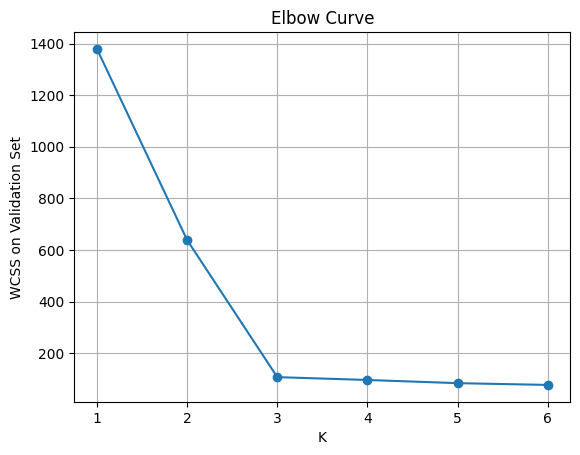

In [18]:
line1 = "Kmax=6"
line2 = "iterations=10"
Kmax = int(line1.split('=')[1])
max_iters = int(line2.split('=')[1])
train = np.loadtxt('../train.csv', delimiter=',')
val = np.loadtxt('../val.csv', delimiter=',')
test = np.loadtxt('../test.csv', delimiter=',')
WCSS_val = []
for K in range(1, Kmax+1):
    centroids, labels = kmeans(train, K, max_iters, seed=0)
    val_labels = assign_clusters(val, centroids)
    wcss = compute_wcss(val, val_labels, centroids)
    WCSS_val.append(round(wcss, 2))
elbow_K = kneedle_elbow(Kmax, WCSS_val)
centroids, labels = kmeans(train, elbow_K, max_iters, seed=0)
test_labels = assign_clusters(test, centroids)
test_wcss = compute_wcss(test, test_labels, centroids)
test_j = test_wcss / test.shape[0]
print(f"Elbow_K={elbow_K}")
print(f"WCSS_Val={WCSS_val}")
print(f"Test_J_Elbow={test_j:.2f} Test_WCSS_Elbow={test_wcss:.2f}")
plt.figure()
plt.plot(range(1, Kmax+1), WCSS_val, marker='o')
plt.xlabel('K')
plt.ylabel('WCSS on Validation Set')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()


# SVM

## SVM1 - Assembly AI

In [1]:
import numpy as np


In [3]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        # Where y <= 0 put -1 else put 1
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

SVM classification accuracy 1.0


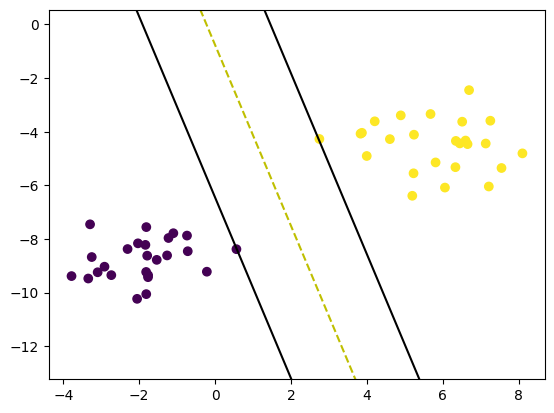

In [6]:
X, y = datasets.make_blobs(
    n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
clf = SVM()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
print("SVM classification accuracy", accuracy(y_test, predictions))
def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)
    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])
    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)
    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)
    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)
    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")
    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    plt.show()
visualize_svm()

## SVM Code

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def load_data(path):
    data = pd.read_csv(path)
    X = data[['x1', 'x2']].values
    y = data['y'].values
    return X, y

In [19]:
train_file = '../svm_train.csv'
val_file = '../svm_val.csv'
test_file = '../svm_test.csv'

In [20]:
# Assumes that y[i] is already -1 and 1
class LinearSVM:
    def __init__(self, c=1.0, lr=0.001, epochs=1000):
        self.c = c
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0

        for epoch in range(self.epochs):
            idxs = np.arange(n)
            np.random.shuffle(idxs)
            for i in idxs:
                condition = y[i] * (np.dot(X[i], self.w) + self.b)
                if condition >= 1:
                    self.w -= self.lr * self.w
                else:
                    self.w -= self.lr * (self.w - self.c * y[i] * X[i])
                    self.b += self.lr * self.c * y[i]


    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [23]:
def plot_decision_boundary(X, y, model_func, title, support_vectors=None, filename=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='b', label='Class +1')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='r', label='Class -1')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
    plt.contour(xx, yy, Z, levels=[-1, 1], colors='grey', linestyles='--')

    if support_vectors is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                    s=80, facecolors='none', edgecolors='k', label='Support Vectors')

    plt.title(title)
    plt.legend()
    if filename:
        plt.savefig(filename)
        print(f"Saved {filename}")
    plt.show()


Training Linear SVM using SGD...
C=0.01: val_acc=0.50
C=0.1: val_acc=0.50
C=1: val_acc=0.70
C=10: val_acc=0.77
C=100: val_acc=0.78
Selected Linear SVM: C=100, val_acc=0.78, test_acc=0.83
Saved linear_decision_boundary.png


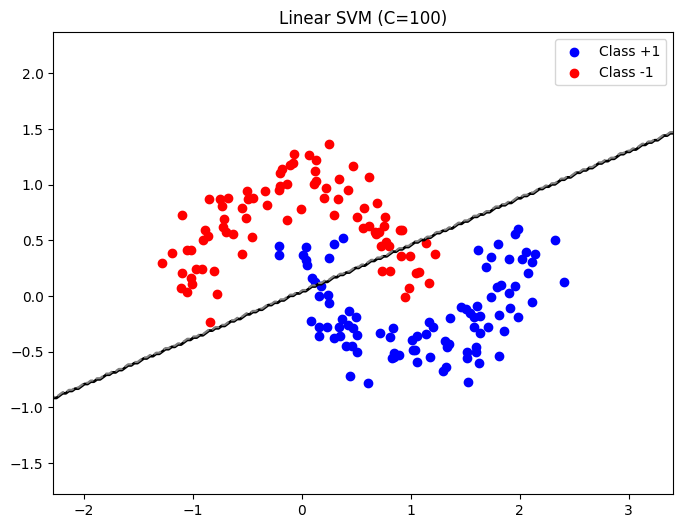

In [24]:
X_train, y_train = load_data(train_file)
X_val, y_val = load_data(val_file)
X_test, y_test = load_data(test_file)
# -------- Linear SVM --------
print("\nTraining Linear SVM using SGD...")
best_val_acc, best_C = 0, None
for C in [0.01, 0.1, 1, 10, 100]:
    model = LinearSVM(c=C, lr=0.001, epochs=500)
    model.fit(X_train, y_train)
    val_acc = np.mean(model.predict(X_val) == y_val)
    print(f"C={C}: val_acc={val_acc:.2f}")
    if val_acc > best_val_acc:
        best_val_acc, best_C, best_model = val_acc, C, model
test_acc = np.mean(best_model.predict(X_test) == y_test)
print(f"Selected Linear SVM: C={best_C}, val_acc={best_val_acc:.2f}, test_acc={test_acc:.2f}")
plot_decision_boundary(X_train, y_train, lambda X: best_model.predict(X),
                       f"Linear SVM (C={best_C})", filename="linear_decision_boundary.png")

## SVM2 Kernels

### RBF Kernel

In [27]:
def rbf_kernel(x1, x2, sigma):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

In [28]:
def poly_kernel(x1, x2, degree=3):
    return (np.dot(x1, x2) + 1) ** degree

In [29]:
class KernelSVM:
    def __init__(self, c=1.0, kernel='rbf', sigma=1.0, degree=3.0, tol=1e-3, max_passes=5):
        self.c = c
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.tol = tol
        self.max_passes = max_passes

    def fit(self, X, y):
        n = len(X)
        self.X, self.y = X, y
        self.alpha = np.zeros(n)
        self.b = 0
        k = self.compute_kernel_matrix(X)

        passes = 0
        while passes < self.max_passes:
            num_changed = 0
            for i in range(n):
                ei = np.dot((self.alpha * y), k[:, i]) + self.b - y[i]
                if (y[i] * ei < -self.tol and self.alpha[i] < self.c) or (y[i] * ei > self.tol and self.alpha[i] > 0):
                    j = np.random.choice([x for x in range(n) if x != i])
                    ej = np.dot((self.alpha * y), k[:, j]) + self.b - y[j]

                    alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]
                    if y[i] != y[j]:
                        l = max(0, self.alpha[j] - self.alpha[i])
                        h = min(self.c, self.c + self.alpha[j] - self.alpha[i])
                    else:
                        l = max(0, self.alpha[i] + self.alpha[j] - self.c)
                        h = min(self.c, self.alpha[i] + self.alpha[j])
                    if l == h:
                        continue

                    eta = 2 * k[i, j] - k[i, i] - k[j, j]
                    if eta >= 0:
                        continue

                    self.alpha[j] -= y[j] * (ei - ej) / eta
                    self.alpha[j] = np.clip(self.alpha[j], l, h)
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue

                    self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])
                    b1 = self.b - ei - y[i] * (self.alpha[i] - alpha_i_old) * k[i, i] - y[j] * (self.alpha[j] - alpha_j_old) * k[i, j]
                    b2 = self.b - ej - y[i] * (self.alpha[i] - alpha_i_old) * k[i, j] - y[j] * (self.alpha[j] - alpha_j_old) * k[j, j]
                    if 0 < self.alpha[i] < self.c:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.c:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
                    num_changed += 1
            if num_changed == 0:
                passes += 1
            else:
                passes = 0
        
        self.support_indices = np.where(self.alpha > 1e-5)[0]
        print(f"Training done. {len(self.support_indices)} support vectors found.")

    def project(self, X):
        result = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for alpha, yi, xi in zip(self.alpha, self.y, self.X):
                if alpha > 1e-5:
                    if self.kernel == 'rbf':
                        s += alpha * yi * rbf_kernel(X[i], xi, self.sigma)
                    else:
                        s += alpha * yi * poly_kernel(X[i], xi, self.degree)
            result[i] = s
        return result + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))
    
    def compute_kernel_matrix(self, X):
        n = len(X)
        k = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if self.kernel == 'rbf':
                    k[i, j] = rbf_kernel(X[i], X[j], self.sigma)
                else:
                    k[i, j] = poly_kernel(X[i], X[j], self.degree)

        return k



Training RBF Kernel SVM using SMO...
Training done. 180 support vectors found.
RBF C=0.01, sigma=0.1: val_acc=0.50
Training done. 175 support vectors found.
RBF C=0.01, sigma=0.3: val_acc=0.50
Training done. 173 support vectors found.
RBF C=0.01, sigma=1: val_acc=0.50
Training done. 167 support vectors found.
RBF C=0.01, sigma=3: val_acc=0.50
Training done. 178 support vectors found.
RBF C=0.1, sigma=0.1: val_acc=0.52
Training done. 130 support vectors found.
RBF C=0.1, sigma=0.3: val_acc=0.95
Training done. 106 support vectors found.
RBF C=0.1, sigma=1: val_acc=0.80
Training done. 156 support vectors found.
RBF C=0.1, sigma=3: val_acc=0.72
Training done. 135 support vectors found.
RBF C=1, sigma=0.1: val_acc=0.97
Training done. 42 support vectors found.
RBF C=1, sigma=0.3: val_acc=0.97
Training done. 55 support vectors found.
RBF C=1, sigma=1: val_acc=0.88
Training done. 84 support vectors found.
RBF C=1, sigma=3: val_acc=0.78
Training done. 134 support vectors found.
RBF C=10, sigma

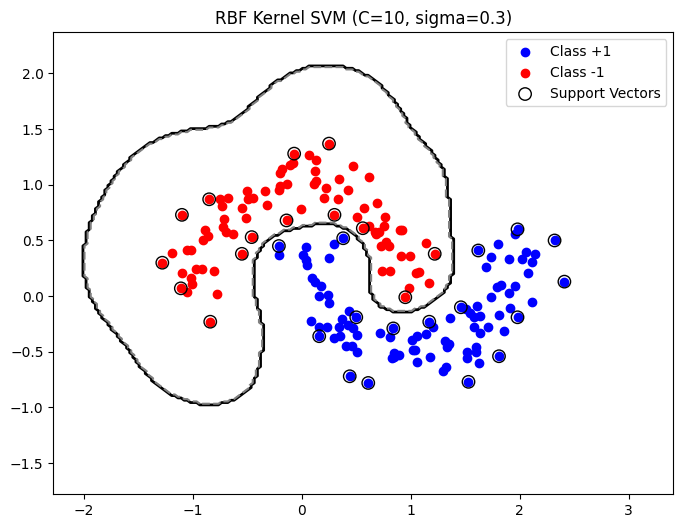

In [30]:
# -------- Kernel SVM (RBF) --------
print("\nTraining RBF Kernel SVM using SMO...")
best_val_acc, best_params = 0, None
for C in [0.01, 0.1, 1, 10, 100]:
    for sigma in [0.1, 0.3, 1, 3]:
        model = KernelSVM(c=C, kernel='rbf', sigma=sigma)
        model.fit(X_train, y_train)
        val_acc = np.mean(model.predict(X_val) == y_val)
        print(f"RBF C={C}, sigma={sigma}: val_acc={val_acc:.2f}")
        if val_acc > best_val_acc:
            best_val_acc, best_params, best_rbf = val_acc, (C, sigma), model
test_acc = np.mean(best_rbf.predict(X_test) == y_test)
print(f"Selected RBF SVM: C={best_params[0]}, sigma={best_params[1]}, val_acc={best_val_acc:.2f}, test_acc={test_acc:.2f}")
plot_decision_boundary(X_train, y_train, lambda X: best_rbf.predict(X),
                       f"RBF Kernel SVM (C={best_params[0]}, sigma={best_params[1]})",
                       support_vectors=X_train[best_rbf.support_indices],
                       filename="rbf_decision_boundary.png")

### Polynomial Kernel

In [31]:
# -------- Polynomial Kernel --------
print("\nTraining Polynomial Kernel SVMs...")
best_val_acc, best_poly_C = 0, None
for C in [0.01, 0.1, 1, 10, 100]:
    model = KernelSVM(c=C, kernel='poly', degree=3)
    model.fit(X_train, y_train)
    val_acc = np.mean(model.predict(X_val) == y_val)
    print(f"Poly C={C}: val_acc={val_acc:.2f}")
    if val_acc > best_val_acc:
        best_val_acc, best_poly_C, best_poly = val_acc, C, model
test_acc = np.mean(best_poly.predict(X_test) == y_test)
print(f"Selected Polynomial SVM (deg=3): C={best_poly_C}, val_acc={best_val_acc:.2f}, test_acc={test_acc:.2f}")
# Final Summary
print("\nFINAL SUMMARY")
print(f"Linear SVM: C={best_C}, val_acc={best_val_acc:.2f}, test_acc={test_acc:.2f}")
print(f"RBF SVM: C={best_params[0]}, sigma={best_params[1]}, val_acc={best_val_acc:.2f}, test_acc={test_acc:.2f}")
print(f"Poly SVM (deg=3): C={best_poly_C}, val_acc={best_val_acc:.2f}, test_acc={test_acc:.2f}")


Training Polynomial Kernel SVMs...
Training done. 97 support vectors found.
Poly C=0.01: val_acc=0.78
Training done. 56 support vectors found.
Poly C=0.1: val_acc=0.85
Training done. 30 support vectors found.
Poly C=1: val_acc=0.95
Training done. 16 support vectors found.
Poly C=10: val_acc=0.97
Training done. 12 support vectors found.
Poly C=100: val_acc=0.97
Selected Polynomial SVM (deg=3): C=10, val_acc=0.97, test_acc=0.98

FINAL SUMMARY
Linear SVM: C=100, val_acc=0.97, test_acc=0.98
RBF SVM: C=10, sigma=0.3, val_acc=0.97, test_acc=0.98
Poly SVM (deg=3): C=10, val_acc=0.97, test_acc=0.98


# Decision Trees

## Assembly AI

In [23]:
import numpy as np
from collections import Counter

In [29]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def _is_leaf(self):
        return self.value is not None
        

In [30]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=10, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        
        # Find best Split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._get_information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold
    
    def _get_information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return - np.sum([p * np.log(p) for p in ps if p > 0])
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value
        

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node._is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [31]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [32]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

In [36]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [37]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

In [38]:
acc = accuracy(y_test, predictions)
print(acc)

0.9385964912280702
